# Introduction

Here, I’m implementing a simple autoencoder with a custom loss function for single-cell RNA-seq data imputation. This approach is inspired by [Badsha et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7144625/), who proposed an fairly elegant autoencoder-based method for imputing missing values in single-cell datasets.

![Figure 1A of Badsha et al. 2020](images/autoencoder.png)
*Figure 1A of Badsha et al. 2020*

Single-cell sequencing technologies have revolutionized biology with the ability of measuring molecular phenotypes (e.g., gene expression) in individual cells. However, due to technical limitations, single-cell gene expression data often contain a large number of zeros many of which do not indicate no expression, but are rather technical artifacts. In the [Badsha et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7144625/) paper, they treat zeros as missing values and develop nonparametric deep learning methods for imputation. Specifically, they developed model called LATE (Learning with AuToEncoder) that trains an autoencoder with random initial values of the parameters, whereas the method called TRANSLATE (TRANSfer learning with LATE) further allows for the use of a reference gene expression data set to provide LATE with an initial set of parameter estimates. The original code from the publication: https://github.com/audreyqyfu/LATE/tree/master.



# Methods

To reproduce their method, I’ll first build a basic autoencoder for gene expression data from scRNA-seq. Then, I'll modify the loss function to focus learning on the observed (non-missing) values, encouraging the model to recover true biological signal rather than fitting noise caused by caused by dropout events (missing data points).

Using real gene expression data sets (from bulk tissues and single cells) in human and mouse (see section of “Data availability”), we generated several synthetic data sets, including the input and the corresponding ground truth, for assessing the performance of imputation methods (summary statistics of the data sets in Supplementary Table S1).

Several methods have been developed recently to impute missing values in scRNA-seq data. Some methods, such as MAGIC and scImpute, use similarity among cells for imputation, whereas other methods, including SAVER (Single-cell Analysis Via Expression Recovery), DCA (Deep Count Autoencoder) and scVI (single-cell Variational Inference), rely on similarity among genes. The latter methods effectively treat cells as independent samples and model the read counts in scRNA-seq data with a negative binomial distribution. Additionally, DCA and scVI take a deep learning approach and develop deep neural networks also based on autoencoders. However, whereas DCA and scVI assume read counts to follow a negative binomial distribution and estimate parameters of this distribution as part of the inference with their autoencoders, LATE does not make explicit assumptions on read counts. ALRA (Adaptively-thresholded Low-Rank Approximation) performs randomized Singular Value Decomposition (SVD) on the gene expression matrix; whether the genes or cells are features is irrelevant with this approach. This aspect is similar to the LATE/TRANSLATE methods that can take either genes or cells as features. Additionally, scVI accounts for batch effects in their statistical model and removes batch effects in imputation. Other methods, including LATE/TRANSLATE, do not address batch effects.

Here, I'll focus on this synthetic PBMC_G949_10K dataset based on the 10x Genomics PBMC data with known cell types downloaded from https://github.com/audreyqyfu/LATE/tree/master/data .


![Figure 5A of Badsha et al. 2020](images/tsne_PBMC_G949_10K_new.png)
*Figure 5A of Badsha et al. 2020: tSNE plots of cells from the synthetic data based on the 10x Genomics PBMC data with known cell types (PBMC_G949_10K; 949 genes and 10K cells)*

In [7]:
# Load required libraries
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


import torch
from torch import nn
import pytorch_model_summary as pms 

from torch.utils.data import TensorDataset, DataLoader

from pytorchtools import EarlyStopping

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

import psutil
import os
def usage():
    '''return RAM usage in Mb'''
    process = psutil.Process(os.getpid())
    ram = process.memory_info()[0] / float(2 ** 20)
    ram = round(ram, 1)
    return ram
usage()

Using cpu device


932.4

In [8]:
# Load input data
fname_input = "data/single_cell/example.hd5"
df_tmp = pd.read_hdf(fname_input)
number_0 = (df_tmp != 0).sum().sum()
print("shape is {}".format(df_tmp.shape))
print('non-zero count is {}'.format( number_0 ))
print('non-zero rate  is {:.3f}'.format(number_0 / df_tmp.size ))

# log10 transformation of the input data
input_df = np.log10( df_tmp.transpose() + 1 ).transpose()
m, n = input_df.shape  # m: n_cells; n: n_genes
print('input_matrix: {} cells, {} genes\n'.format(m, n))
print(input_df.head())


shape is (10000, 949)
non-zero count is 3155953
non-zero rate  is 0.333
input_matrix: 10000 cells, 949 genes

                  ENSG00000187608  ENSG00000175756  ENSG00000242485  \
Barcode                                                               
GTAATATGGTGTTG-1          0.00000          0.00000              0.0   
GAGCGCTGCTGACA-3          0.00000          0.30103              0.0   
AAGGTCTGATTGGC-4          0.00000          0.00000              0.0   
CAATATGAAGAGTA-8          0.00000          0.00000              0.0   
TACATAGAGCTGTA-2          0.30103          0.00000              0.0   

                  ENSG00000160075  ENSG00000162585  ENSG00000157873  \
Barcode                                                               
GTAATATGGTGTTG-1          0.30103              0.0              0.0   
GAGCGCTGCTGACA-3          0.00000              0.0              0.0   
AAGGTCTGATTGGC-4          0.00000              0.0              0.0   
CAATATGAAGAGTA-8          0.00000    

In [9]:
# cell type label, extracted from 
# https://github.com/10XGenomics/single-cell-3prime-paper/blob/master/pbmc68k_analysis/68k_pbmc_barcodes_annotation.tsv
cell_types = pd.read_csv('data/single_cell/example.cellType.csv' , index_col=0)
print(cell_types)
print(cell_types.celltype.value_counts())

                                      celltype
Barcode                                       
GTAATATGGTGTTG-1  CD8+/CD45RA+ Naive Cytotoxic
GAGCGCTGCTGACA-3              CD8+ Cytotoxic T
AAGGTCTGATTGGC-4                      CD56+ NK
CAATATGAAGAGTA-8               CD4+/CD25 T Reg
TACATAGAGCTGTA-2    CD4+/CD45RA+/CD25- Naive T
...                                        ...
AAAGTTTGTACTTC-1  CD8+/CD45RA+ Naive Cytotoxic
CAAAGCTGCTTGAG-3              CD8+ Cytotoxic T
ACAATCCTTCTAGG-6  CD8+/CD45RA+ Naive Cytotoxic
ATTTCGTGATGCCA-7              CD8+ Cytotoxic T
AGTTTAGAGTATGC-7  CD8+/CD45RA+ Naive Cytotoxic

[10000 rows x 1 columns]
celltype
CD8+ Cytotoxic T                3004
CD8+/CD45RA+ Naive Cytotoxic    2450
CD56+ NK                        1266
CD4+/CD25 T Reg                  899
CD19+ B                          878
CD4+/CD45RO+ Memory              428
CD14+ Monocyte                   426
Dendritic                        334
CD4+/CD45RA+/CD25- Naive T       261
CD34+                

In [10]:
# get training and validation datasets
valid_fraction = 0.3
valid_size = int( m * valid_fraction )
train_size = m - valid_size

np.random.seed(1884)
arr = np.arange(m)
np.random.shuffle(arr)

X_train = input_df.iloc[ arr[:train_size] , : ].to_numpy() # training dataset
X_valid = input_df.iloc[ arr[train_size:] , : ].to_numpy() # validation dataset

print('train: {}'.format(train_size))
print('valid: {}'.format(valid_size))

cell_type_train = list( cell_types.loc[ input_df.index[ arr[:train_size] ] , 'celltype' ] )
cell_type_valid = list( cell_types.loc[ input_df.index[ arr[train_size:] ] , 'celltype' ] )

gene_ids = input_df.columns
train_cell_ids = input_df.index[ arr[:train_size] ]
valid_cell_ids = input_df.index[ arr[train_size:] ]

train: 7000
valid: 3000


<Axes: >

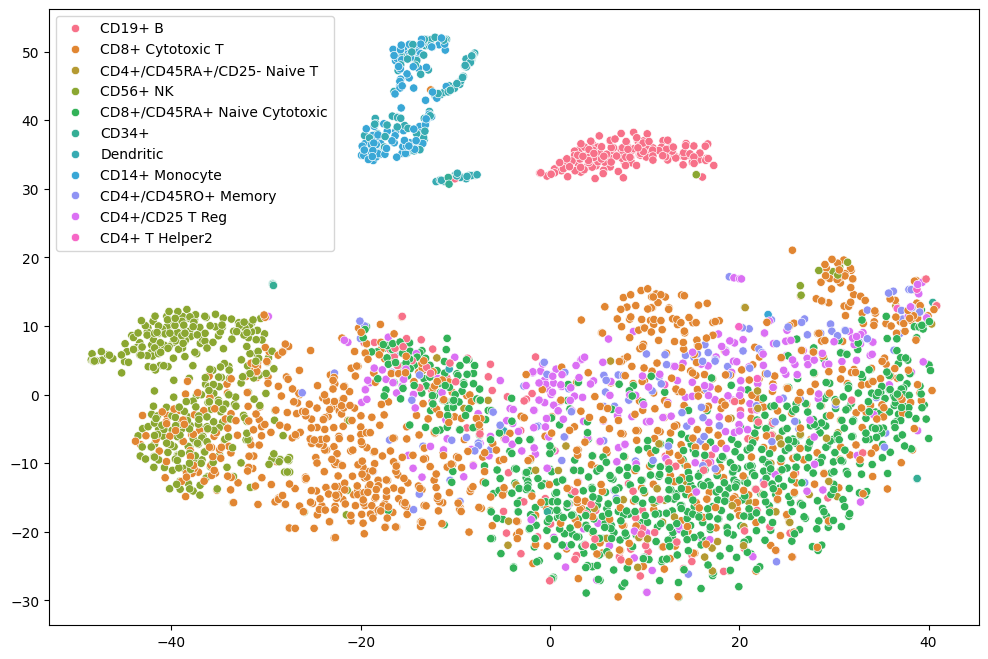

In [11]:
# it applies PCA to the validation data (X_valid) to reduce noise and retain the top 100 principal components; 
# then, it applies t-SNE to those 100 components to project the data into 2D space. 
# it plots the 2D t-SNE representation, coloring points based on their corresponding cell types

pca_valid = PCA().fit( X_valid )
x_pca = pca_valid.transform( X_valid )
pca_valid.explained_variance_ratio_[:10]
np.cumsum( pca_valid.explained_variance_ratio_ )[ 100 ]
tsne = TSNE(n_components=2)
tsne.fit( x_pca[:,:100] )
fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

In [12]:
# build the dataLoaders, with a batch size of 256
batch_size = 256
# create dataset
train_dataset = TensorDataset( torch.Tensor(X_train) ) 
## creating a dataloader
train_dataloader = DataLoader( train_dataset , batch_size = batch_size ) 
# create dataset
valid_dataset = TensorDataset( torch.Tensor(X_valid) ) 
## creating a dataloader
valid_dataloader = DataLoader(valid_dataset , batch_size = batch_size )

In [13]:
# simple autoencoder

class Simple_AutoEncoder(torch.nn.Module):
    
    def __init__(self , input_dim = 949 , 
                         hidden_dim=[500] ,
                         latent_dim = 100 , 
                         dropout_fraction = 0.25):
        super().__init__()
        
        self.encoder = nn.Sequential(  )
        self.decoder = nn.Sequential(  )
        
        encoder_dimensions = [input_dim] + hidden_dim + [latent_dim] 
        decoder_dimensions = encoder_dimensions[::-1]
         
        for i in range(1,len(encoder_dimensions)):            
            self.encoder.append( nn.Dropout(dropout_fraction) )
            self.encoder.append( nn.Linear(encoder_dimensions[i-1], encoder_dimensions[i]) )
            self.encoder.append( nn.ReLU() )
            
        for i in range(1,len(decoder_dimensions)):            
            self.decoder.append( nn.Dropout(dropout_fraction) )
            self.decoder.append( nn.Linear(decoder_dimensions[i-1], decoder_dimensions[i]) )
            self.decoder.append( nn.ReLU() )
            
        
    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)

    def encode(self,x):
        with torch.no_grad():
            self.eval()
            return self.encoder(x)


model = Simple_AutoEncoder().to(device)
print(model)
print(pms.summary(model, torch.zeros(1,949).to(device), show_input=True))

Simple_AutoEncoder(
  (encoder): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=949, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=100, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, out_features=949, bias=True)
    (5): ReLU()
  )
)
-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
         Dropout-1            [1, 949]               0               0
          Linear-2            [1, 949]         475,000         475,000
            ReLU-3            [1, 500]               0               0
         Dropout-4            [1, 500]               0               0
          Linear-5   

In [14]:
# the loss here is Mean Squared Error between the input and the output
model.eval()
x, = valid_dataset[:5] ## let's go with a batch of 5 samples

mseloss = nn.MSELoss()

with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
    x = x.to(device)
    pred = model(x)
    print( "input shape:", x.shape)
    print( "prediction shape:", pred.shape)
    print("mean squared error:", mseloss(pred,x))

input shape: torch.Size([5, 949])
prediction shape: torch.Size([5, 949])
mean squared error: tensor(0.1300)


In [15]:
# training the model
def train(dataloader, model, loss_fn, optimizer , patience = 10 ,  echo = True , echo_batch = False):
    
    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.
    
    for batch, (X,) in enumerate(dataloader): # for each batch
        X = X.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred, X)      # loss function from these prediction        
        
        # Backpropagation
        loss.backward()              # backward propagation 
        #                            https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
        #                            https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
        
        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        if echo_batch:
            current =  (batch) * dataloader.batch_size +  len(X)
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    
    if echo:
        print(f"Train loss: {loss.item():>7f}")

    # return the last batch loss
    return loss.item()

def valid(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    valid_loss = 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for (X,) in dataloader:
            X = X.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, X).item()  ## accumulating the loss function over the batches
            
    valid_loss /= num_batches

    if echo:
        print(f"Valid Error: {valid_loss:>8f}")
    ## return the average loss / batch
    return valid_loss


## preamble -> define the model, the loss function, and the optimizer
model = Simple_AutoEncoder(  input_dim = len(gene_ids) , 
                             hidden_dim=[500] ,
                             latent_dim = 100 , 
                             dropout_fraction = 0.05).to(device)


mseloss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), 
                       lr = 3*10**-4) # using the learning rate from author's code


## container to keep the scores across all epochs
train_scores = []
valid_scores = []


# Overfitting can be an issue here. 
# Iuse the early stopping implemented in https://github.com/Bjarten/early-stopping-pytorch
# initialize the early_stopping object. 
# patience: How long to wait after last time validation loss improved.
early_stopping = EarlyStopping(patience=25, verbose=False)

In [16]:
%%time
## lets do a single round, to learn how long it takes
train_scores.append( train(train_dataloader, 
                           model, 
                           mseloss, 
                           optimizer, 
                           echo = True , echo_batch = True ) )

valid_scores.append( valid(valid_dataloader, 
                           model, 
                           mseloss , 
                           echo = True) )


Train loss: 0.112348  [  256/ 7000]
Train loss: 0.110049  [  512/ 7000]
Train loss: 0.109498  [  768/ 7000]
Train loss: 0.108522  [ 1024/ 7000]
Train loss: 0.107447  [ 1280/ 7000]
Train loss: 0.098600  [ 1536/ 7000]
Train loss: 0.092237  [ 1792/ 7000]
Train loss: 0.091634  [ 2048/ 7000]
Train loss: 0.084215  [ 2304/ 7000]
Train loss: 0.079846  [ 2560/ 7000]
Train loss: 0.074694  [ 2816/ 7000]
Train loss: 0.071357  [ 3072/ 7000]
Train loss: 0.066136  [ 3328/ 7000]
Train loss: 0.062341  [ 3584/ 7000]
Train loss: 0.054160  [ 3840/ 7000]
Train loss: 0.053113  [ 4096/ 7000]
Train loss: 0.052426  [ 4352/ 7000]
Train loss: 0.047558  [ 4608/ 7000]
Train loss: 0.045797  [ 4864/ 7000]
Train loss: 0.043556  [ 5120/ 7000]
Train loss: 0.043120  [ 5376/ 7000]
Train loss: 0.042904  [ 5632/ 7000]
Train loss: 0.041749  [ 5888/ 7000]
Train loss: 0.041020  [ 6144/ 7000]
Train loss: 0.040572  [ 6400/ 7000]
Train loss: 0.040033  [ 6656/ 7000]
Train loss: 0.038923  [ 6912/ 7000]
Train loss: 0.036820  [ 7000

In [17]:
%%time

epoch = 200

for t in range(epoch):
    echo = t%10==0
    if echo:
        print('Epoch',len(train_scores)+1 )    

    train_scores.append( train(train_dataloader, 
                               model, 
                               mseloss, 
                               optimizer, 
                               echo = echo , echo_batch = False ) )

    valid_scores.append( valid(valid_dataloader, 
                               model, 
                               mseloss , 
                               echo = echo) )

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_scores[-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 2
Train loss: 0.033538
Valid Error: 0.033870
Epoch 12
Train loss: 0.024969
Valid Error: 0.025430
Epoch 22
Train loss: 0.022800
Valid Error: 0.023555
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 1 out of 25
Epoch 32
Train loss: 0.021927
Valid Error: 0.023040
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Epoch 42
Train loss: 0.021102
Valid Error: 0.022728
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Epoch 52
Train loss: 0.020415
Valid Error: 0.023223
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 1

<All keys matched successfully>

Text(0, 0.5, 'MSE loss')

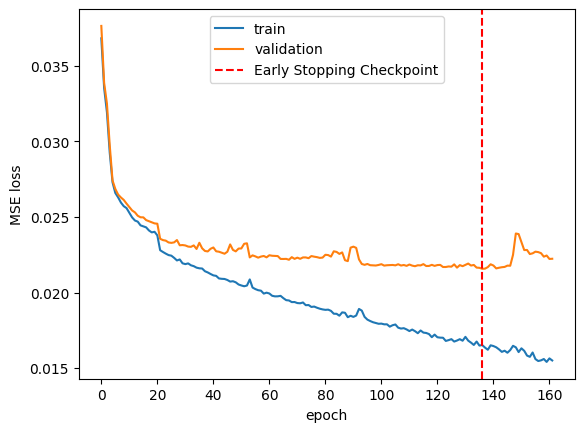

In [18]:
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.axvline(np.argmin(valid_scores), linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

<Axes: >

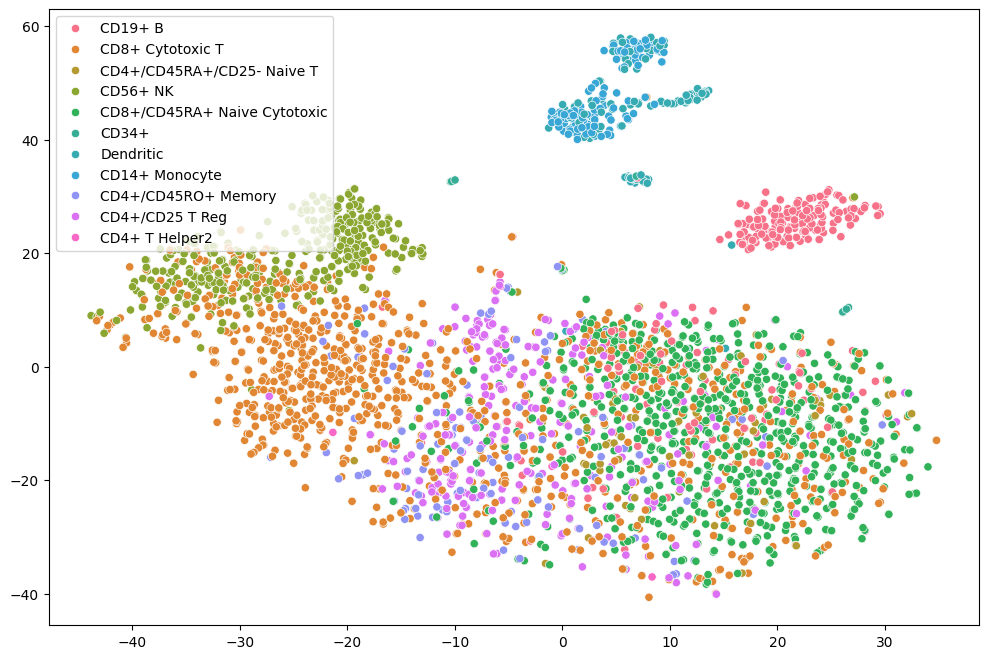

In [19]:
# The plot shows whether the model has learned to separate or group different cell types.
# Training learns useful compressed representations. t-SNE visualizes those learned representations after training.
x, = valid_dataset[:]
valid_encoded = model.encode( x.to(device) )
tsne = TSNE(n_components=2)
tsne.fit( valid_encoded.cpu().numpy() )

fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

## From autoencoder to imputer

“from autoencoder to imputer” — is to turn the autoencoder into a missing data imputation tool
In a typical autoencoder: The model learns to reconstruct its full input, minimizing the reconstruction loss across all input features.
In an imputer: The goal is different: reconstruct or predict only the missing parts of the input, using the available data.

By adjusting the loss to focus only on non-missing values, the autoencoder becomes a model that learns to fill in missing data — turning it from a reconstruction tool into a data imputation tool.


shape is (10000, 949)
non-zero count is 949319
non-zero rate  is 0.100
train: 7000
valid: 3000


<Axes: >

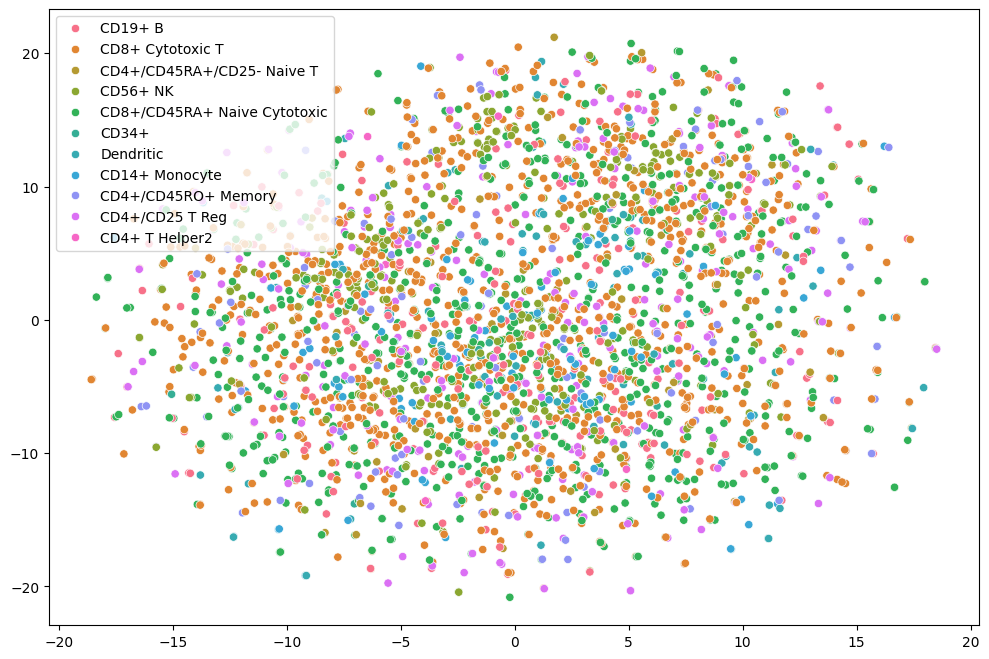

In [30]:
# Synthetic dataset for testing
## same as the original dataset, but with 90% of 0s (30% missing in the previous dataset is not enough for show-casing)
fname_input = "data/single_cell/example.msk90.hd5"
df_tmp = pd.read_hdf(fname_input)
number_0 = (df_tmp != 0).sum().sum()
print("shape is {}".format(df_tmp.shape))
print('non-zero count is {}'.format( number_0 ))
print('non-zero rate  is {:.3f}'.format(number_0 / df_tmp.size ))

## log10 transformation 
pseudocount = 1
input_sparse_df = np.log10( df_tmp.transpose() + pseudocount ).transpose()

valid_fraction = 0.3
valid_size = int( m * valid_fraction )
train_size = m - valid_size
np.random.seed(1884)
arr = np.arange(m)
np.random.shuffle(arr)

X_train = input_sparse_df.iloc[ arr[:train_size] , : ].to_numpy()
X_valid = input_sparse_df.iloc[ arr[train_size:] , : ].to_numpy()

print('train: {}'.format(train_size))
print('valid: {}'.format(valid_size))

cell_type_train = list( cell_types.loc[ input_sparse_df.index[ arr[:train_size] ] , 'celltype' ] )
cell_type_valid = list( cell_types.loc[ input_sparse_df.index[ arr[train_size:] ] , 'celltype' ] )

gene_ids = input_df.columns
train_cell_ids = input_df.index[ arr[:train_size] ]
valid_cell_ids = input_df.index[ arr[train_size:] ]

pca_valid = PCA().fit( X_valid )
x_pca = pca_valid.transform( X_valid )
pca_valid.explained_variance_ratio_[:10]

tsne = TSNE(n_components=2)
tsne.fit( x_pca[:,:100] )
fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

In [31]:
# Build data loaders
batch_size = 256
# create your dataset
train_dataset = TensorDataset( torch.Tensor(X_train) ) 
## creating a dataloader
train_dataloader = DataLoader( train_dataset , batch_size = batch_size ) 
# create your dataset
valid_dataset = TensorDataset( torch.Tensor(X_valid) ) 
## creating a dataloader
valid_dataloader = DataLoader(valid_dataset , batch_size = batch_size )
x, = train_dataset[:]
print(torch.sum( x == 0 ) / torch.numel( x ))
x, = valid_dataset[:]
print(torch.sum( x == 0 ) / torch.numel( x ))

tensor(0.8999)
tensor(0.9001)


In [32]:
%%time

# A custom loss function designed to compute Mean Squared Error (MSE) only on non-zero values in the target tensor
# This loss function assumes:
#    - Zeros in the target should be ignored during training (treated as missing).
#    - The model focuses on reconstructing only observed (non-zero) data points.
def maskedMeanSquareError(output, target):
    non_zero_mask = (target!=0)
    SE = torch.sum((output - target)**2 * non_zero_mask)
    N0 = torch.sum(non_zero_mask)
    return SE/N0


## preamble -> define the model, the loss function, and the optimizer
model = Simple_AutoEncoder(  input_dim = len(gene_ids) , 
                             hidden_dim=[500] ,
                             latent_dim = 100 , 
                             dropout_fraction = 0.05).to(device)

#############################################
## Here we specify our custom loss function
mseloss = maskedMeanSquareError
#############################################

optimizer = torch.optim.Adam(model.parameters(), 
                       lr = 3*10**-4) ## using the learning rate from their code

## container to keep the scores across all epochs
train_scores = []
valid_scores = []

# Overfitting can be an issue here. 
# I use the early stopping implemented in https://github.com/Bjarten/early-stopping-pytorch
# to initialize the early_stopping object. 
# patience: How long to wait after last time validation loss improved.
early_stopping = EarlyStopping(patience=25, verbose=False)

## lets do a single round, to learn how long it takes
train_scores.append( train(train_dataloader, 
                           model, 
                           mseloss, 
                           optimizer, 
                           echo = True , echo_batch = True ) )

valid_scores.append( valid(valid_dataloader, 
                           model, 
                           mseloss , 
                           echo = True) )
                           
epoch = 200

for t in range(epoch):
    echo = t%10==0
    if echo:
        print('Epoch',len(train_scores)+1 )    

    train_scores.append( train(train_dataloader, 
                               model, 
                               mseloss, 
                               optimizer, 
                               echo = echo , echo_batch = False ) )

    valid_scores.append( valid(valid_dataloader, 
                               model, 
                               mseloss , 
                               echo = echo) )

    # early_stopping needs the validation loss to check if it has decreased, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_scores[-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

Train loss: 0.340915  [  256/ 7000]
Train loss: 0.340436  [  512/ 7000]
Train loss: 0.334625  [  768/ 7000]
Train loss: 0.331891  [ 1024/ 7000]
Train loss: 0.331890  [ 1280/ 7000]
Train loss: 0.316757  [ 1536/ 7000]
Train loss: 0.302797  [ 1792/ 7000]
Train loss: 0.307638  [ 2048/ 7000]
Train loss: 0.291324  [ 2304/ 7000]
Train loss: 0.282530  [ 2560/ 7000]
Train loss: 0.264344  [ 2816/ 7000]
Train loss: 0.250341  [ 3072/ 7000]
Train loss: 0.223900  [ 3328/ 7000]
Train loss: 0.207078  [ 3584/ 7000]
Train loss: 0.187308  [ 3840/ 7000]
Train loss: 0.173410  [ 4096/ 7000]
Train loss: 0.157351  [ 4352/ 7000]
Train loss: 0.152167  [ 4608/ 7000]
Train loss: 0.151946  [ 4864/ 7000]
Train loss: 0.148550  [ 5120/ 7000]
Train loss: 0.145324  [ 5376/ 7000]
Train loss: 0.139951  [ 5632/ 7000]
Train loss: 0.129214  [ 5888/ 7000]
Train loss: 0.112420  [ 6144/ 7000]
Train loss: 0.104415  [ 6400/ 7000]
Train loss: 0.096728  [ 6656/ 7000]
Train loss: 0.094909  [ 6912/ 7000]
Train loss: 0.093584  [ 7000

<All keys matched successfully>

Text(0, 0.5, 'MSE loss')

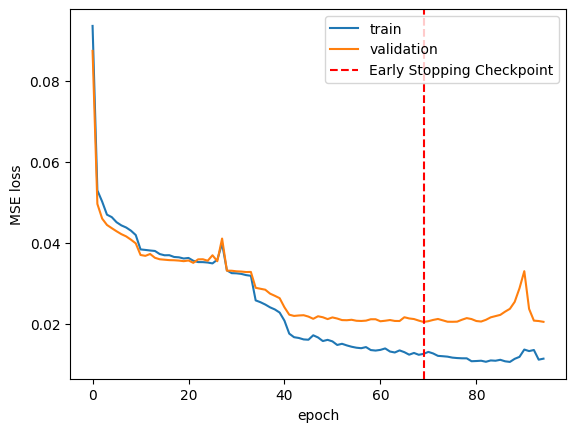

In [33]:
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.axvline(np.argmin(valid_scores), linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

<Axes: >

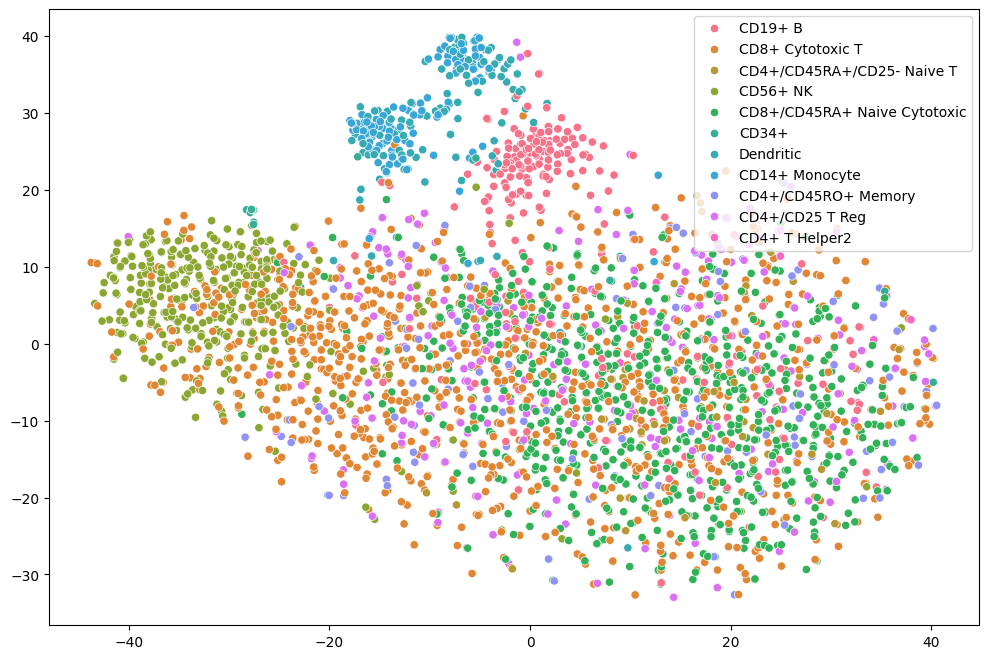

In [34]:
x, = valid_dataset[:]
valid_encoded = model.encode( x.to(device) )
tsne = TSNE(n_components=2)
tsne.fit( valid_encoded.cpu().numpy() )

fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

It looks like our masked encoder has retrieved some of the data structure despite the heavy sparsity!

In [35]:
## imputation 
with torch.no_grad():
    x, = train_dataset[:]
    train_imputed = model( x.to(device) ).cpu().numpy()
    x, = valid_dataset[:]
    valid_imputed = model( x.to(device) ).cpu().numpy()

## load ground truth
df_truth = pd.read_hdf('data/single_cell/example.hd5')
## log10 transformation 
pseudocount = 1
df_truth = np.log10( df_truth.transpose() + pseudocount ).transpose()
print(df_truth)

                  ENSG00000187608  ENSG00000175756  ENSG00000242485  \
Barcode                                                               
GTAATATGGTGTTG-1          0.00000         0.000000          0.00000   
GAGCGCTGCTGACA-3          0.00000         0.301030          0.00000   
AAGGTCTGATTGGC-4          0.00000         0.000000          0.00000   
CAATATGAAGAGTA-8          0.00000         0.000000          0.00000   
TACATAGAGCTGTA-2          0.30103         0.000000          0.00000   
...                           ...              ...              ...   
AAAGTTTGTACTTC-1          0.00000         0.000000          0.00000   
CAAAGCTGCTTGAG-3          0.00000         0.301030          0.00000   
ACAATCCTTCTAGG-6          0.30103         0.000000          0.30103   
ATTTCGTGATGCCA-7          0.00000         0.477121          0.00000   
AGTTTAGAGTATGC-7          0.00000         0.000000          0.00000   

                  ENSG00000160075  ENSG00000162585  ENSG00000157873  \
Barco

<Axes: >

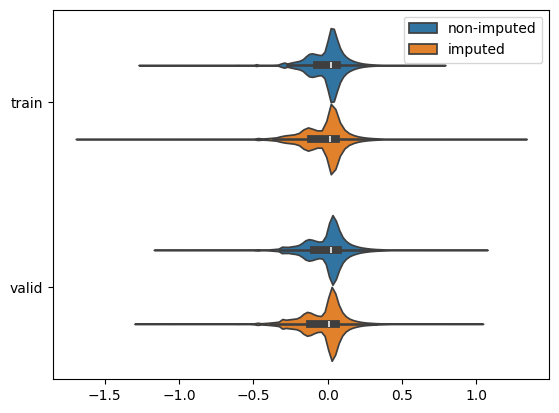

In [36]:
## imputation 
with torch.no_grad():
    x, = train_dataset[:]
    train_imputed = model( x.to(device) ).cpu().numpy()
    x, = valid_dataset[:]
    valid_imputed = model( x.to(device) ).cpu().numpy()

## load ground truth
df_truth = pd.read_hdf('data/single_cell/example.hd5')
## log10 transformation 
pseudocount = 1
df_truth = np.log10( df_truth.transpose() + pseudocount ).transpose()

truth_train = np.array( df_truth.loc[ train_cell_ids , : ] )
truth_valid = np.array( df_truth.loc[ valid_cell_ids , : ] )

## the "ground truth" data already had ~67% of missing data, 
##  we do not want to focus on this for the solution assessment

train_NI_mask = ( truth_train != 0 ) & ( X_train != 0 ) # non imputed data
train_I_mask = ( truth_train != 0 ) & ( X_train == 0 ) # imputed data with a ground truth

valid_NI_mask = ( truth_valid != 0 ) & ( X_valid != 0 ) # non imputed data
valid_I_mask = ( truth_valid != 0 ) & ( X_valid == 0 ) # imputed data with a ground truth

# difference of non imputed in train
train_non_imputed_diff = ( train_imputed[ train_NI_mask ] - truth_train[ train_NI_mask ] )
# difference of imputed in train
train_imputed_diff = ( train_imputed[ train_I_mask ] - truth_train[ train_I_mask ] )

# difference of non imputed in valid
valid_non_imputed_diff = ( valid_imputed[ valid_NI_mask ] - truth_valid[ valid_NI_mask ] )
# difference of imputed in valid
valid_imputed_diff = ( valid_imputed[ valid_I_mask ] - truth_valid[ valid_I_mask ] )


sizes = (train_non_imputed_diff.shape[0],
         train_imputed_diff.shape[0],
         valid_non_imputed_diff.shape[0],
         valid_imputed_diff.shape[0])

sns.violinplot(x = np.concatenate( [train_non_imputed_diff ,
                                    train_imputed_diff , 
                                    valid_non_imputed_diff, 
                                    valid_imputed_diff]),
            y = ['train']*(sizes[0]+sizes[1]) + ['valid']*(sizes[2]+sizes[3]),
            hue = ['non-imputed']*sizes[0] + ['imputed']*sizes[1] + ['non-imputed']*sizes[2] + ['imputed']*sizes[3] )

This violin plot shows the error distribution between model’s output and the true gene expression values, split into:
- Non-imputed data (blue): where the model reconstructed known values.
- Imputed data (orange): where the model predicted missing (masked) values.

# Results

This simple model can both reconstruct observed values and impute missing values without large bias. The errors are small and centered around zero for both reconstructed and imputed data, suggesting that the autoencoder has learned a reasonable latent representation of the gene expression data.